In [1]:
import numpy as np
import alkompy as ay
import time
import matplotlib.pyplot as plt

In [2]:
code = """

#version 450

  layout(set = 0, binding = 0) readonly buffer AMatrix {
      vec2 size;
      float data[];
  } aMatrix;

  layout(set = 0, binding = 1) readonly buffer BMatrix {
      vec2 size;
      float data[];
  } bMatrix;

  layout(set = 0, binding = 2) buffer RMatrix {
      vec2 size;
      float data[];
  } rMatrix;

  void main() {
    rMatrix.size = vec2(aMatrix.size.x, bMatrix.size.y);

    ivec2 resultCell = ivec2(gl_GlobalInvocationID.x, gl_GlobalInvocationID.y);
    float result = 0.0;
    for (int i = 0; i < aMatrix.size.y; i++) {
      int a = i + resultCell.x * int(aMatrix.size.y);
      int b = resultCell.y + i * int(bMatrix.size.y);
      result += aMatrix.data[a] * bMatrix.data[b];
    }

    int index = resultCell.y + resultCell.x * int(bMatrix.size.y);
    rMatrix.data[index] = result;
  }

"""

In [3]:
shader = ay.compile_glsl(code)

In [4]:
def rand_matrix_a_and_b(n):
    A = np.random.rand(n,n).astype(np.float32)
    B = np.random.rand(n,n).astype(np.float32)
    return A, B

def prepare_for_gpu(A, B, n):

    a = A.flatten()
    b = B.flatten()

    a = np.insert(a, 0, [n,n])
    b = np.insert(b, 0, [n,n])
    r = np.zeros(n * n + 2, dtype=np.float32)

    return a, b, r

In [5]:
n = 10

A, B = rand_matrix_a_and_b(n)
a, b, r = prepare_for_gpu(A, B, n)

In [6]:
device = ay.Device(0)
a_gpu = device.to_device(a)
b_gpu = device.to_device(b)
r_gpu = device.to_device(r)

In [7]:
device.run("main", shader, (n, n, 1), [a_gpu, b_gpu, r_gpu])

In [8]:
res = device.get(r_gpu)

In [9]:
np.isclose(res[2:].reshape((n,n)), (A.dot(B)))

array([[ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True],
       [ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True]])

In [14]:
num_size = [2**i for i in range(1, 10)] + list(range(512, 1024, 100))  

prep_time = []
gpu_time = []
cpu_time = []

for n in num_size:
    print(n)

    # Preperation
    start_time = time.time()

    A, B = rand_matrix_a_and_b(n)
    a, b, r = prepare_for_gpu(A, B, n)
    total_time = time.time() - start_time
    prep_time.append(total_time)

    # GPU
    start_time = time.time()

    a_gpu = device.to_device(a)
    b_gpu = device.to_device(b)
    r_gpu = device.to_device(r)

    device.run("main", shader, (n, n, 1), [a_gpu, b_gpu, r_gpu])
    # res = device.get(r_gpu)

    total_time = time.time() - start_time
    gpu_time.append(total_time)

    # CPU
    start_time = time.time()
    res = A.dot(B)

    total_time = time.time() - start_time
    cpu_time.append(total_time)



2
4
8
16
32
64
128
256
512
512
612
712
812
912
1012


&lt;matplotlib.legend.Legend at 0x7f7e2d634490&gt;

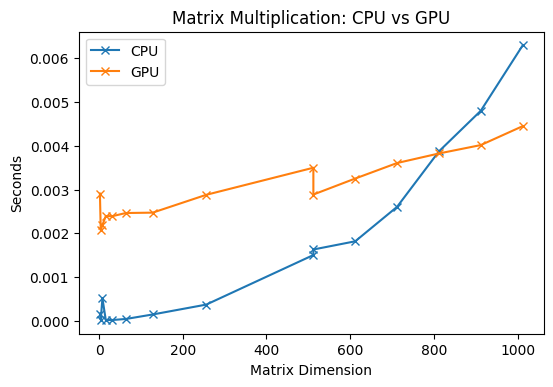

In [15]:
plt.figure(dpi=100)
plt.plot(num_size, cpu_time, '-x', label='CPU')
plt.plot(num_size, gpu_time, '-x', label='GPU')
plt.xlabel('Matrix Dimension')
plt.ylabel('Seconds')
plt.title("Matrix Multiplication: CPU vs GPU")
plt.legend()